In [ ]:
%pip install tqdm
%pip install wandb --upgrade

In [ ]:
import wandb
import os
import torch
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torchvision.datasets as datasets
from scipy.stats import gaussian_kde
from scipy.stats import norm
from random import randint
import torch.distributions as dist
import math

In [ ]:
wandb.login(key=)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

parameters_dict = {
    'latent_dim': {
        'value':10},
    'num_epochs':{
        'value':20},
    'batch_size':{
        'value':16},
    'learning_rate':{
        'value':3.5e-4},
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='MNIST 7 layer optimised')
project='MNIST 7 layer optimised'
folder_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}"
os.makedirs(folder_path)

Create sweep with ID: jk42fxyf
Sweep URL: https://wandb.ai/t-a-emm-20/MNIST%207%20layer%20optimised/sweeps/jk42fxyf


torch.Size([50000, 1, 28, 28])


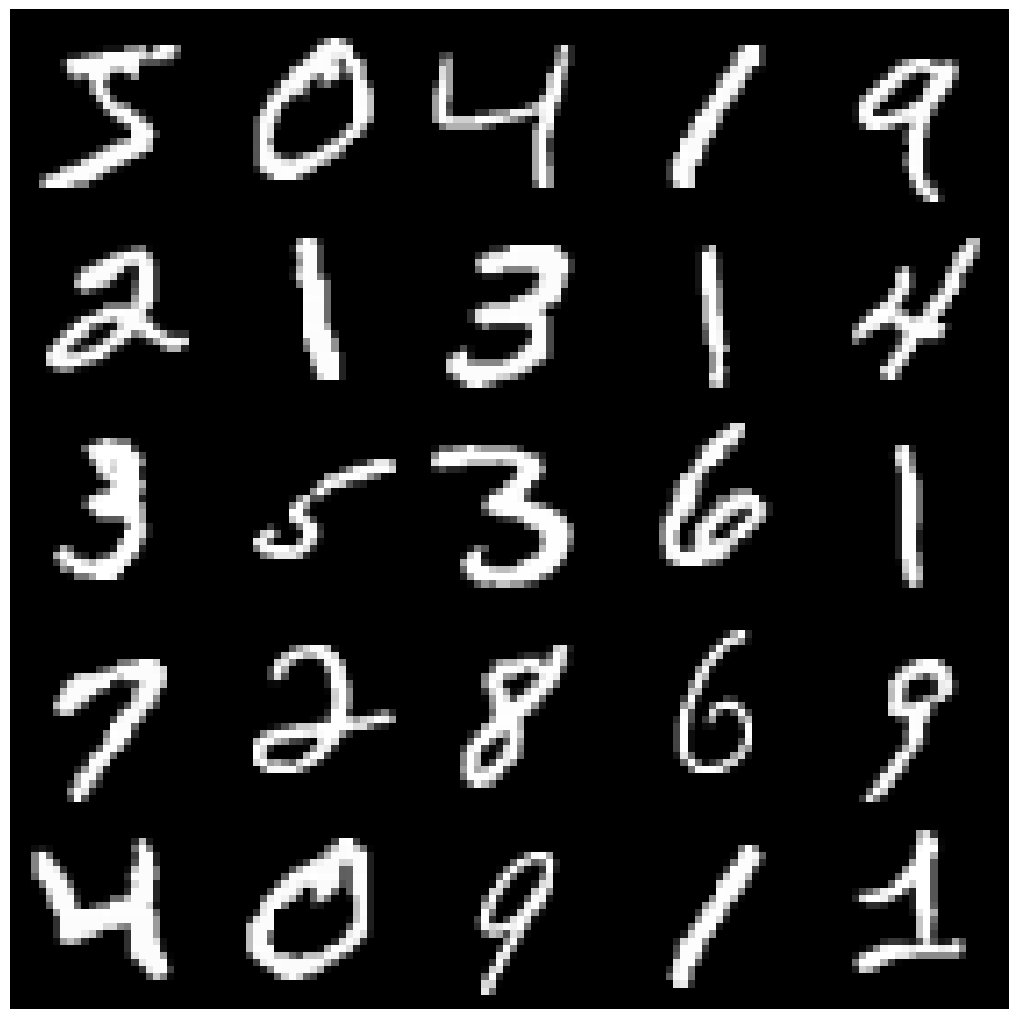

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

print(train_dataset.shape)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
      super().__init__()
      #encoding
      self.in_lay=nn.Linear(input_dim,1600)
      self.enclay1=nn.Linear(1600,800)
      self.mu=nn.Linear(800,latent_dim)
      self.logstd=nn.Linear(800,latent_dim)

      #deocoding
      self.declay1=nn.Linear(latent_dim,800)
      self.declay2=nn.Linear(800,1600)
      self.out_lay=nn.Linear(1600,input_dim)

      self.relu=nn.ReLU()

    def encode(self,x):
        el1=self.relu(self.in_lay(x))
        el2=self.relu(self.enclay1(el1))
        mu=self.mu(el2)
        logstd=self.logstd(el2)

        return mu, logstd

    def decode(self, z):
        dl1=self.relu(self.declay1(z))
        dl2=self.relu(self.declay2(dl1))

        return torch.sigmoid(self.out_lay(dl2))

    def forward(self,x):
        mu, logstd = self.encode(x)
        std=torch.exp(logstd)
        eps = torch.randn_like(logstd)
        z_reparam = mu + std*eps
        z_prior = torch.randn_like(logstd)
        x_recon = self.decode(z_reparam)

        return x_recon, mu, logstd, z_prior, z_reparam

In [ ]:
def loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior):
    recon_loss=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='sum')
    kl_div = -0.5*torch.sum(1+logstd-mu.pow(2)-(torch.exp(logstd)).pow(2))

    def imq_kernel(z1,z2):
        Cbase = (2* latent_dim * kernel_bandwidth**2)
        k =0
        for scale in scales:
            C=scale*Cbase

            k+= C/(C + torch.norm(z1.unsqueeze(1)-z2.unsqueeze(0),dim=-1) ** 2)
        return k

    k_z=imq_kernel(z_reparam,z_reparam)
    k_z_prior=imq_kernel(z_prior,z_prior)
    k_cross=imq_kernel(z_reparam,z_prior)

    mmd_z=(k_z - k_z.diag().diag()).sum()/((n-1)*n)
    mmd_z_prior=(k_z_prior-k_z_prior.diag().diag()).sum()/((n-1)*n)
    mmd_cross=k_cross.sum()/(n**2)
    mmd_loss=mmd_z+mmd_z_prior-2*mmd_cross

    return recon_loss, kl_div, mmd_loss

In [ ]:
def fitness_func(alpha, lbd, recon_loss, kl_div, mmd_loss, loss):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    loss_new = recon_loss + (1-alpha)*kl_div + (alpha + lbd -1)*mmd_loss
    fitness=loss-loss_new

    return fitness.to(device)

In [ ]:
def SBX(pop_size, mutation_rate, eta, crossover_rate, alpha_tprev, lbd_tprev, recon_loss, kl_div, mmd_loss, loss):
    pop=[(dist.Normal(alpha_tprev,0.05).sample(), dist.Normal(lbd_tprev,3).sample())for n in range(pop_size)]
    fit_scores=[fitness_func(alpha_t,lbd_t, recon_loss, kl_div, mmd_loss, loss) for alpha_t, lbd_t in pop]
    sorted_ind=sorted(range(len(fit_scores)), key=lambda i: fit_scores[i], reverse=True)
    sorted_pop=[pop[i] for i in sorted_ind]
    prt=torch.rand(1)
    fit_probs=torch.softmax(torch.tensor(fit_scores), dim=0)
    new_pop=[]

    parent = torch.multinomial(fit_probs.clone().detach(),1, replacement=False)
    alpha_t, lbd_t=sorted_pop[parent]
    if prt<crossover_rate:
        u=torch.rand(1).to(device)
        if u <= 0.5:
            rc=(2*u)**(1/(eta+1))
        else:
            rc=(1/(2*(1-u)))**(1/(eta+1))
        cpop=[]
        alpha1=0.5*((1+rc)*alpha_t + (1-rc)*alpha_tprev)
        lbd1=0.5*((1+rc)*lbd_t + (1-rc)*lbd_tprev)
        cpop.append((alpha1,lbd1))

        alpha2=0.5*((1-rc)*alpha_t + (1+rc)*alpha_tprev)
        lbd2=0.5*((1-rc)*lbd_t + (1+rc)*lbd_tprev)
        cpop.append((alpha2,lbd2))

        cfit_scores=[fitness_func(alpha_tplus1, lbd_tplus1, recon_loss, kl_div, mmd_loss, loss) for alpha_tplus1, lbd_tplus1 in cpop]
        sorted_scores= sorted(range(len(cfit_scores)), key=lambda i: cfit_scores[i], reverse=True)
        sorted_cpop=[cpop[i] for i in sorted_scores]

        alpha_tplus1, lbd_tplus1 = sorted_cpop[0]

        if prt<mutation_rate:
            m=torch.tensor(random.uniform(-4,4)).to(device)
            rm=0.25*((1/math.pi)*(1/(1+m**2)))
            alpha_tplus1= alpha_tplus1 + rm
            l=torch.tensor(random.uniform(-4,4)).to(device)
            rm=0.25*((1/math.pi)*(1/(1+l**2)))
            lbd_tplus1= lbd_tplus1 + rm
            new_pop.append((alpha_tplus1, lbd_tplus1))

        else:
            new_pop.append((alpha_tplus1, lbd_tplus1))

    if prt<mutation_rate:
        m=torch.tensor(random.uniform(-4,4)).to(device)
        rm=0.25*((1/math.pi)*(1/(1+m**2)))
        alpha_tplus1= alpha_t + rm
        l=torch.tensor(random.uniform(-4,4)).to(device)
        rm=0.25*((1/math.pi)*(1/(1+l**2)))
        lbd_tplus1= lbd_t + rm
        new_pop.append((alpha_tplus1, lbd_tplus1))

    else:
        alpha_tplus1, lbd_tplus1 = sorted_pop[1]
        new_pop.append((alpha_tplus1, lbd_tplus1))

    alpha_star, lbd_star = max(new_pop, key=lambda ind: fitness_func(ind[0], ind[1], recon_loss, kl_div, mmd_loss, loss))
    return alpha_star, lbd_star


In [ ]:
def train(config=None):
    wandb.init(config = config)
    config=wandb.config


    input_dim=784
    latent_dim=config.latent_dim
    num_epochs=config.num_epochs
    batch_size=config.batch_size
    learning_rate=config.learning_rate
    alpha=torch.tensor(random.uniform(-0.5,0.5)).to(device)
    lbd=random.uniform(25,100)
    scales = [0.1, 0.2, 0.5, 1.0, 2.0, 5, 10.0]
    kernel_bandwidth=1

    pop_size=8
    num_gen=2
    eta=7
    mutation_rate=0.2
    crossover_rate=0.3

    #dataset
    train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size)
    model=VariationalAutoEncoder(input_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    z_star=[]

    #train
    for epoch in range(num_epochs):
        loop=tqdm(enumerate(train_loader))
        #batch_recon=[]
        #batch_kl_div=[]
        #batch_mmd=[]


        for i, x in loop:
            x=x.to(device).view(x.shape[0],input_dim)
            x_recon, mu, var, z_prior, z_reparam =model(x)
            n=z_reparam.shape[0]
            z_star.append(z_reparam.detach())
            #print(mu)

            recon_loss, kl_div, mmd_loss=loss_function(x, x_recon, mu, var, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior)

            #batch_recon.append(recon_loss)
            #batch_kl_div.append(kl_div)
            #batch_mmd.append(mmd_loss)

        #epoch_recon=torch.mean(torch.stack(batch_recon))
        #epoch_kl_div=torch.mean(torch.stack(batch_kl_div))
        #epoch_mmd=torch.mean(torch.stack(batch_mmd))

            loss= recon_loss + (1-alpha)*kl_div + (alpha + lbd -1)*mmd_loss

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

            wandb.log({'loss':loss,'epoch':epoch,'recon loss':recon_loss,'kl diverg':kl_div,'mmd loss':mmd_loss})

        alpha_star, lbd_star= SBX(pop_size, mutation_rate, eta, crossover_rate, alpha, lbd, recon_loss, kl_div, mmd_loss, loss)
        alpha=alpha_star
        lbd=lbd_star
        wandb.log({'alpha':alpha, 'lbd':lbd})


    #Sample
    gen_imgs=[]
    num_samples=25
    full_batch_nbr=int(num_samples/batch_size)
    last_batch_nbr=num_samples % batch_size

    for i in range(num_samples):
        z_gen=torch.zeros(10)
        for j in range(latent_dim):
            z_gen[j]=torch.tensor(np.random.normal(loc=0, scale=1.1, size=1))
        #print(z_gen)
        z_gen=z_gen.to(device)
        x_gen=model.decode(z_gen).detach()
        gen_img=x_gen.reshape(1,28,28)
        gen_imgs.append(gen_img)
    gen_imgs=torch.stack(gen_imgs)


    #Plot
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i][j].imshow(gen_imgs[i*5 +j].cpu().squeeze(0), cmap='gray')
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.)

    run_name=wandb.run.name
    run_gen='generated'
    run_gen_name=run_name+run_gen
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_gen_name}.png"
    plt.savefig(img_path)


    #Reconstruction
    to_recon=[]
    hi=[1,3,5,7,9,0,18,15,17,4]
    for i in range(10):
        to_recon.append(train_dataset[hi[i]])

    to_recon_imgs=torch.stack(to_recon)

    recond=[]
    rec_errors=[]
    for i in range(10):
        x=to_recon_imgs[i].to(device).view(1,input_dim)
        x_recon, mu, logstd, z_prior, z_reparam =model(x)
        recon_error=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='mean')
        x_recon_img=x_recon.reshape(1,28,28)
        recond.append(x_recon_img.detach())
        rec_errors.append(recon_error.detach())

    recond_imgs=torch.stack(recond)
    print(rec_errors)

    fig3, axes3 = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
    for i in range(10):
        axes3[0][i].imshow(to_recon_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[0][i].axis('off')
        axes3[1][i].imshow(recond_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[1][i].axis('off')

    plt.tight_layout(pad=0.)
    run_recon='recon'
    run_recon_name=run_name+run_recon
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_recon_name}.png"
    plt.savefig(img_path)

    #Disentanglment Metric
    fixed_metric=randint(0,9)
    num_tests=15
    zldiff=[]

    for j in range(num_tests):
        v1=torch.zeros(latent_dim)
        v2=torch.zeros(latent_dim)

        for i in range(latent_dim):
            v1[i]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            v2[i]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            t=torch.tensor(np.random.normal(loc=0, scale=1., size=1))
            v1[fixed_metric]=t
            v2[fixed_metric]=t
            v1=v1.to(device)
            v2=v2.to(device)

        x1=model.decode(v1).detach()
        x1_img=x1.reshape(1,28,28)
        x2=model.decode(v2).detach()
        x2_img=x2.reshape(1,28,28)

        z1mu, z1logstd=model.encode(x1)
        z2mu, z2logstd=model.encode(x2)
        z1mu=z1mu.detach()
        z2mu=z2mu.detach()

        zldiff.append(abs(z1mu-z2mu))

    zldiff=torch.stack(zldiff)
    zbdiff=(1/num_tests*latent_dim)*torch.sum(zldiff)
    print(zbdiff)
    wandb.log({'zbdiff':zbdiff})

wandb: Agent Starting Run: yaqopdh3 with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:54, 57.73it/s, loss=518]
3125it [00:54, 57.83it/s, loss=449]
3125it [00:54, 57.10it/s, loss=414]
3125it [00:54, 57.17it/s, loss=402]
3125it [00:54, 57.60it/s, loss=389]
3125it [00:54, 57.43it/s, loss=359]
3125it [00:54, 57.52it/s, loss=361]
3125it [00:55, 56.79it/s, loss=341]
3125it [00:53, 57.93it/s, loss=322]
3125it [00:54, 57.43it/s, loss=317]
3125it [00:54, 57.27it/s, loss=294]
3125it [00:56, 55.77it/s, loss=293]
3125it [00:54, 57.43it/s, loss=273]
3125it [00:54, 57.31it/s, loss=265]
3125it [00:54, 57.25it/s, loss=241]
3125it [00:55, 56.04it/s, loss=239]
3125it [00:54, 56.89it/s, loss=227]
3125it [00:54, 57.18it/s, loss=218]
3125it [00:54, 57.07it/s, loss=209]
3125it [00:55, 56.10it/s, loss=194]


[tensor(0.0111, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(0.0206, device='cuda:0'), tensor(0.0113, device='cuda:0'), tensor(0.0103, device='cuda:0'), tensor(0.0364, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(0.0064, device='cuda:0'), tensor(0.0153, device='cuda:0'), tensor(0.0144, device='cuda:0')]
tensor(91.1274, device='cuda:0')


alpha,▁▁▁▁▂▂▂▃▃▄▅▅▅▆▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▂▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▅▆▅▆▆▆▆▆▆▇▆▆▇▇▇▇█
lbd,▄▃▂▁▁▁▂▁▂▁▃▃▄▄▄▅▄▆██
loss,█▅▅▅▄▅▅▄▆▄▃▅▃▄▄▃▃▂▄▃▂▃▃▄▃▂▃▃▃▃▁▁▂▁▂▂▂▁▁▁
mmd loss,▂▄▇▅▄▂▂▂█▂▂▃▃▅▄▂▃▃▃▂▅▃▃▅▂▁▂▃▃▂▂▂▂▂▂▃▃▁▄▃
recon loss,█▅▄▄▃▃▄▃▄▃▁▃▃▂▃▂▂▁▂▂▂▂▃▃▂▂▂▂▃▃▁▁▁▁▂▂▂▁▁▁
zbdiff,▁
alpha,0.87892
epoch,19
kl diverg,206.51678


wandb: Agent Starting Run: oxnaajwo with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:54, 57.61it/s, loss=506]
3125it [00:54, 57.29it/s, loss=471]
3125it [00:54, 57.54it/s, loss=435]
3125it [00:55, 56.35it/s, loss=420]
3125it [00:54, 57.07it/s, loss=396]
3125it [00:54, 56.82it/s, loss=399]
3125it [00:54, 56.94it/s, loss=386]
3125it [00:56, 55.20it/s, loss=370]
3125it [00:54, 57.16it/s, loss=340]
3125it [00:54, 56.89it/s, loss=324]
3125it [00:58, 53.69it/s, loss=336]
3125it [00:57, 54.55it/s, loss=305]
3125it [00:56, 55.42it/s, loss=285]
3125it [00:56, 55.02it/s, loss=287]
3125it [00:57, 54.47it/s, loss=255]
3125it [00:57, 54.41it/s, loss=247]
3125it [00:56, 55.23it/s, loss=235]
3125it [00:55, 56.49it/s, loss=224]
3125it [00:55, 56.79it/s, loss=227]
3125it [00:56, 55.70it/s, loss=209]


[tensor(0.0107, device='cuda:0'), tensor(0.0036, device='cuda:0'), tensor(0.0169, device='cuda:0'), tensor(0.0098, device='cuda:0'), tensor(0.0101, device='cuda:0'), tensor(0.0317, device='cuda:0'), tensor(0.0074, device='cuda:0'), tensor(0.0079, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(0.0182, device='cuda:0')]
tensor(85.8580, device='cuda:0')


alpha,▁▂▂▂▂▃▃▃▃▄▅▅▆▆▆▇▇▇▇█
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▂▃▃▄▄▄▄▄▄▄▅▄▄▄▅▅▄▅▅▅▅▆▅▆▆▇▆▇▇▇▇▇▇▇█████
lbd,▅▄▆▄▃▅▄▄▃▆█▆▆▄▃▃▂▂▂▁
loss,█▆▅▅▄▅▅▄▆▄▂▄▃▃▄▃▃▂▄▃▃▃▃▄▃▂▃▃▃▃▁▁▁▁▂▂▂▁▁▁
mmd loss,▃█▅▆▄▃▂▄▇▅▃▃▂▄▂▃▄▃▃▃▃▂▃▂▅▃▃▅▄▁▃▂▃▃▃▂▃▂▁▅
recon loss,█▅▄▄▃▄▄▃▄▃▂▃▂▂▃▂▂▁▃▂▂▂▃▃▃▂▂▂▂▃▁▁▁▁▂▂▂▁▁▁
zbdiff,▁
alpha,0.90424
epoch,19
kl diverg,208.198


wandb: Agent Starting Run: 6338j32l with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:54, 57.25it/s, loss=501]
3125it [00:54, 56.87it/s, loss=448]
3125it [00:55, 56.45it/s, loss=424]
3125it [00:55, 55.82it/s, loss=395]
3125it [00:55, 56.82it/s, loss=390]
3125it [00:55, 56.74it/s, loss=375]
3125it [00:55, 56.27it/s, loss=344]
3125it [00:56, 55.48it/s, loss=347]
3125it [00:54, 57.07it/s, loss=308]
3125it [00:54, 57.51it/s, loss=316]
3125it [00:54, 57.82it/s, loss=290]
3125it [00:55, 56.19it/s, loss=278]
3125it [00:54, 57.45it/s, loss=249]
3125it [00:54, 57.44it/s, loss=247]
3125it [00:54, 57.79it/s, loss=226]
3125it [00:55, 56.47it/s, loss=209]
3125it [00:54, 57.67it/s, loss=196]
3125it [00:54, 57.54it/s, loss=193]
3125it [00:54, 57.65it/s, loss=166]
3125it [00:55, 56.33it/s, loss=-4.52e+17]


[tensor(0.1432, device='cuda:0'), tensor(0.0997, device='cuda:0'), tensor(0.1134, device='cuda:0'), tensor(0.1398, device='cuda:0'), tensor(0.1090, device='cuda:0'), tensor(0.1082, device='cuda:0'), tensor(0.0735, device='cuda:0'), tensor(0.1135, device='cuda:0'), tensor(0.1093, device='cuda:0'), tensor(0.0830, device='cuda:0')]
tensor(2.7524e+09, device='cuda:0')


alpha,▁▁▁▂▂▂▃▃▃▄▅▅▆▆▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
lbd,██▇▆▄▄▄▅▅▄▃▄▃▁▁▁▃▁▂▃
loss,███████████████████████████████████████▁
mmd loss,▁▁▁▂▁▁▁▁▂▁▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁██
recon loss,▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
zbdiff,▁
alpha,1.15248
epoch,19
kl diverg,4.640735665389044e+18


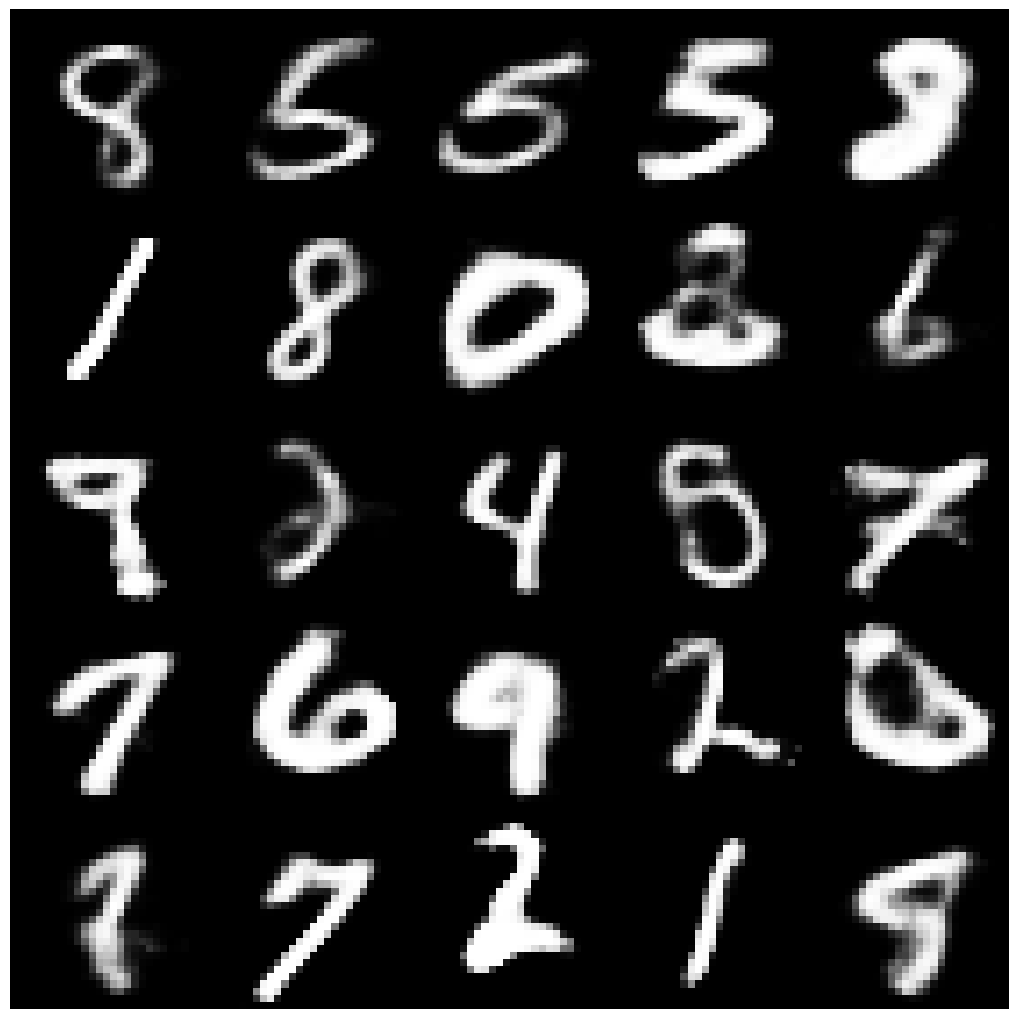

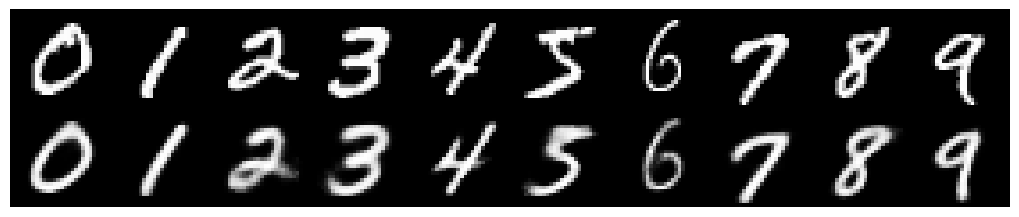

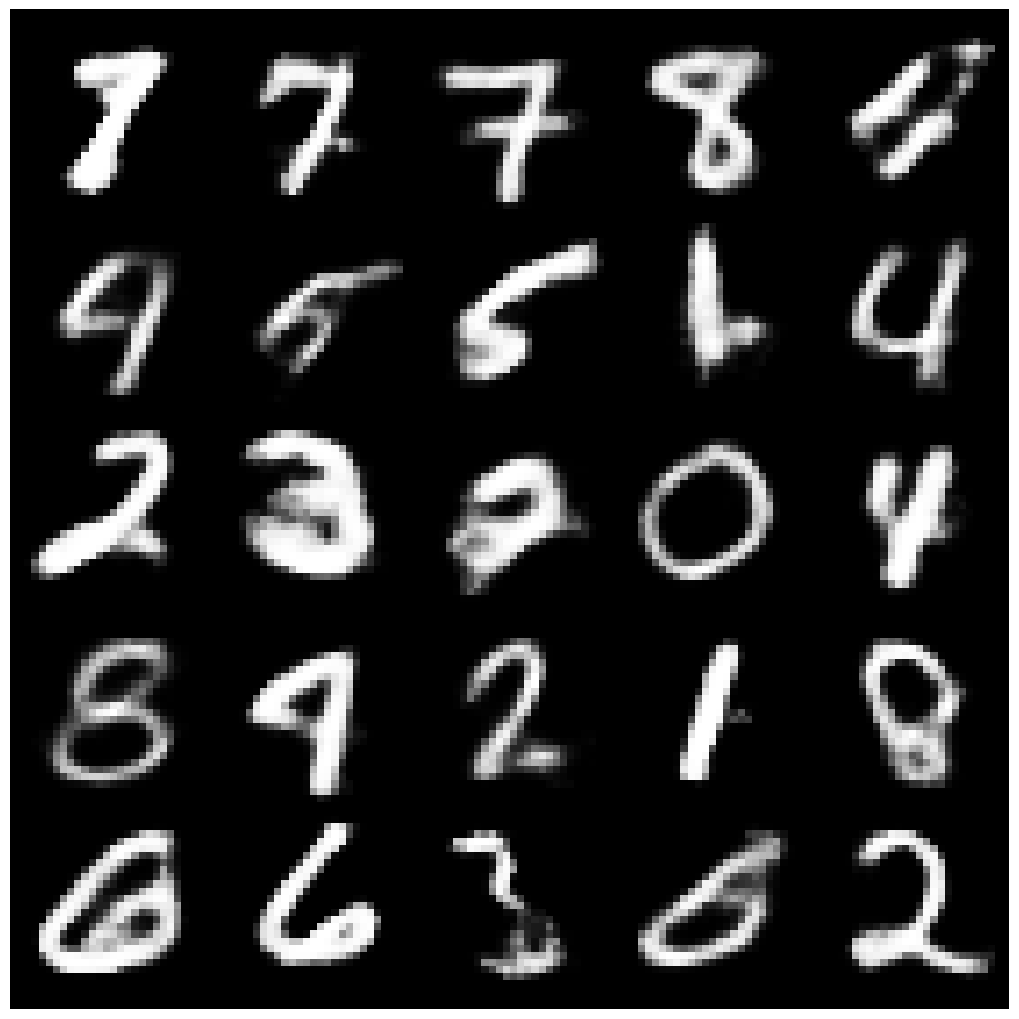

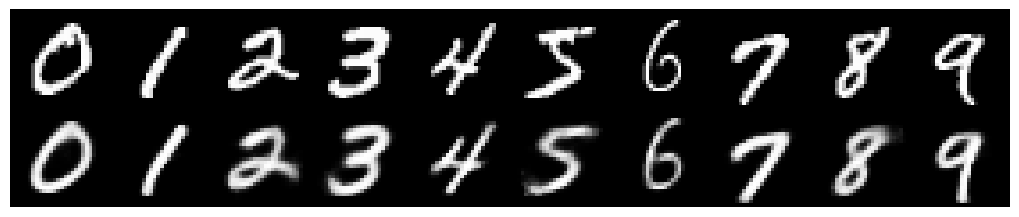

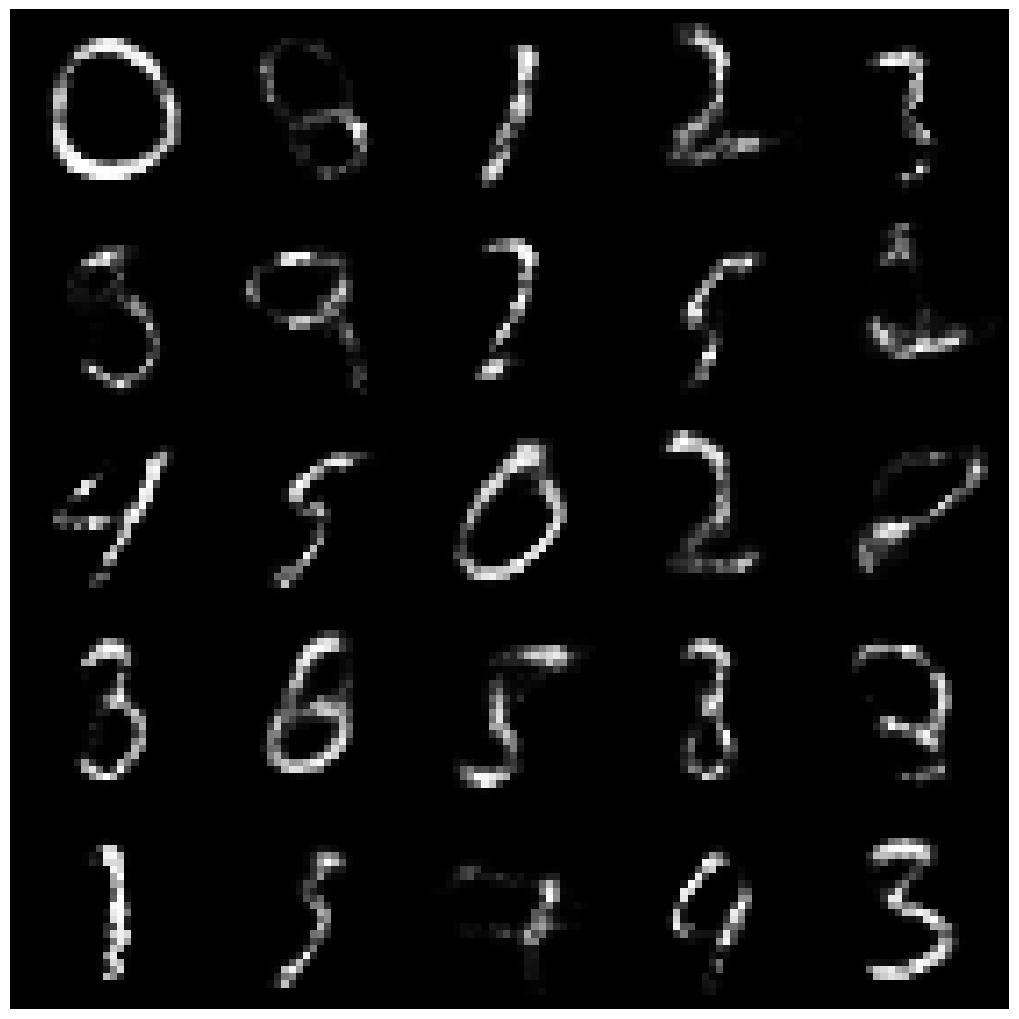

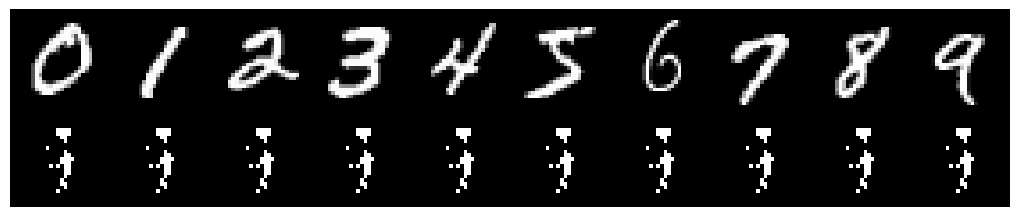

In [ ]:
wandb.agent(sweep_id, train, count=3)